In [1]:
import subprocess
import caffe
caffe.set_mode_cpu()
import numpy as np
import pandas as pd
import h5py
import shutil
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

##Work Flow

###1. Prepare Data
###2. Train and Evaluate Model
###3. Load Serialized Model and Predict 

<br>

##Part 1: Prepare Data 

- **Read in the data and cast as float32**

In [2]:
df = pd.read_csv('data/iris.dat', header=None)

label = df.pop(4).values[:, np.newaxis].astype('float32')
data = df.values.astype('float32')

- **Shuffle and do train-test split on iris data**
- **Scale the train and test data (both according to the train data)**

In [3]:
def scale_train_test(data_train, data_test):
    scaler = StandardScaler().fit(data_train)
    scaled_data_train = scaler.transform(data_train)
    scaled_data_test = scaler.transform(data_test)
    return scaled_data_train, scaled_data_test

def shuffle_train_test_split(data, label, test_size=0.3, rs=42):
    sss = StratifiedShuffleSplit(label, 1, 
                                 test_size=test_size,
                                 random_state=rs)
    sss = list(sss)[0]
    data_train = data[sss[0],]
    label_train = label[sss[0],]

    data_test = data[sss[1],]
    label_test = label[sss[1],]
    
    scaled_data_train, scaled_data_test = scale_train_test(data_train, data_test)
    
    return scaled_data_train, label_train, scaled_data_test, label_test  

In [4]:
data_train, label_train, data_test, label_test = \
                shuffle_train_test_split(data, label)

In [ ]:
print 'Number of Train samples:', data_train.shape[0]
print 'Number of Test samples:', data_test.shape[0]

- **Store data and label as HDF5**
  - Here the dataset is small and it is more convenient to store as HDF5

In [6]:
def make_hdf5(data, label, test_train):
    hdf5_fname = 'data/%s_iris.h5' % test_train
    hdf5_fname_lst = 'data/%s.list' % test_train

    with h5py.File(hdf5_fname, 'w') as f:
        f['data'] = data
        f['label'] = label
    
    with open(hdf5_fname_lst, 'w') as f:
        f.write(hdf5_fname)

In [7]:
make_hdf5(data_train, label_train, 'train')
make_hdf5(data_test, label_test, 'test')

<br>

##Part 2: Train and Evaluate Model

- **Write solver file**
  - The solver file contains all the hyperparameters necessary to train the model

In [8]:
%%writefile model_spec/solver.prototxt
test_iter: 1000
test_interval: 1000
base_lr: 0.01
display: 5
max_iter: 1000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
solver_mode: CPU
snapshot_prefix: "iris_logit" # Write to the model directory
net: "model_spec/net.prototxt"

Writing model_spec/solver.prototxt


- **Write network file**
  - The network file specifies the architecture of the neural net
  - Also how the data is channelled through the model in the training and testing (evaluation) stages

In [9]:
%%writefile model_spec/net.prototxt
name: "LogisticRegressionNet"
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  hdf5_data_param {
    source: "data/train.list"
    batch_size: 105
  }
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  hdf5_data_param {
    source: "data/test.list"
    batch_size: 45
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "data"
  top: "fc1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  inner_product_param {
    num_output: 3
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "fc1"
  bottom: "label"
  top: "loss"
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "fc1"
  bottom: "label"
  top: "accuracy"
  include {
    phase: TEST
  }
}

Writing model_spec/net.prototxt


- **Plot the network configuration**
  - This provides a good way to know if you have specified the network file correctly
  - Requires `pydot` and `pyparsing`
  
    ```bash
    pip uninstall pyparsing
    pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz#md5=9be0fcdcc595199c646ab317c1d9a709
    pip install pydot
    ```

In [10]:
def draw_dag(net_fname): 

    from google.protobuf import text_format
    from caffe.draw import get_pydot_graph
    from caffe.proto import caffe_pb2
    from IPython.display import display, Image 

    net = caffe_pb2.NetParameter()
    f = open(net_fname)
    text_format.Merge(f.read(), net)
    display(Image(get_pydot_graph(net,"TB").create_png()))

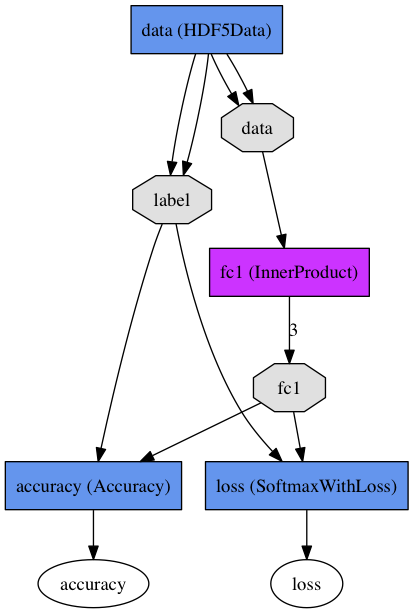

In [11]:
draw_dag("model_spec/net.prototxt")

- **Fit and then evaluate the accuracy of the model**

In [12]:
proc = subprocess.Popen(
    ["caffe", "train", "--solver=model_spec/solver.prototxt"],
    stderr=subprocess.PIPE)
result = proc.communicate()[1]

- **Print the last 10 lines of the evaluation of the model**

In [17]:
print '\n'.join(result.split('\n')[-10:])

I0713 22:50:06.096202 2037363472 solver.cpp:486] Iteration 995, lr = 0.0093133
I0713 22:50:06.096388 2037363472 solver.cpp:361] Snapshotting to iris_logit_iter_1000.caffemodel
I0713 22:50:06.096822 2037363472 solver.cpp:369] Snapshotting solver state to iris_logit_iter_1000.solverstate
I0713 22:50:06.097031 2037363472 solver.cpp:276] Iteration 1000, loss = 0.119508
I0713 22:50:06.097046 2037363472 solver.cpp:294] Iteration 1000, Testing net (#0)
I0713 22:50:06.139744 2037363472 solver.cpp:343]     Test net output #0: accuracy = 0.977782
I0713 22:50:06.139782 2037363472 solver.cpp:343]     Test net output #1: loss = 0.142751 (* 1 = 0.142751 loss)
I0713 22:50:06.139791 2037363472 solver.cpp:281] Optimization Done.
I0713 22:50:06.139796 2037363472 caffe.cpp:134] Optimization Done.



- **Move the binary model files into the model directory**

In [ ]:
_ = subprocess.call('mv *.caffemodel model && mv *.solverstate model', shell=True)

<br>

##Part 3: Load Serialized Model and Predict